In [333]:
# import the usual
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import hashlib 
import datetime
import surprise
from surprise import SVD
from sklearn import preprocessing
%matplotlib inline
pd.set_option('display.max_columns', 500)

### LastFm Data Loading

In [2]:
%%time
df = pd.read_csv("../../Dataset/lastfm/userid-timestamp-artid-artname-traid-traname.tsv", sep="\t", error_bad_lines=False, header = None)

b'Skipping line 2120260: expected 6 fields, saw 8\n'
b'Skipping line 2446318: expected 6 fields, saw 8\n'
b'Skipping line 11141081: expected 6 fields, saw 8\n'
b'Skipping line 11152099: expected 6 fields, saw 12\nSkipping line 11152402: expected 6 fields, saw 8\n'
b'Skipping line 11882087: expected 6 fields, saw 8\n'
b'Skipping line 12902539: expected 6 fields, saw 8\nSkipping line 12935044: expected 6 fields, saw 8\n'
b'Skipping line 17589539: expected 6 fields, saw 8\n'


In [3]:
df.columns = ['userid', 'timestamp', 'artistid', 'artist', '1', 'song']

In [4]:
df.head()

,userid,timestamp,artistid,artist,1,song
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [5]:
df['time'] = pd.to_datetime(df['timestamp'])
df.drop(['timestamp'], axis=1, inplace=True)

In [6]:
df.head()

,userid,artistid,artist,1,song,time
0,user_000001,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,2009-05-04 23:08:57+00:00
1,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15),2009-05-04 13:54:10+00:00
2,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15),2009-05-04 13:52:04+00:00
3,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15),2009-05-04 13:42:52+00:00
4,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15),2009-05-04 13:42:11+00:00


### Removing artist name and song id (possibly) from the user_songs_df dataframe

In [7]:
user_songs_df = df.drop(['artist'], axis=1, inplace=False)
user_songs_df.columns = ['userid', 'artistid', 'songid', 'song', 'time']
user_songs_df = user_songs_df.drop(['songid'], axis=1, inplace=False)

In [8]:
user_songs_df.head()

,userid,artistid,song,time
0,user_000001,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,2009-05-04 23:08:57+00:00
1,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Composition 0919 (Live_2009_4_15),2009-05-04 13:54:10+00:00
2,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Mc2 (Live_2009_4_15),2009-05-04 13:52:04+00:00
3,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Hibari (Live_2009_4_15),2009-05-04 13:42:52+00:00
4,user_000001,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,Mc1 (Live_2009_4_15),2009-05-04 13:42:11+00:00


In [9]:
print('Number of songs : ' + str(user_songs_df['song'].nunique()))

Number of songs : 1083471


In [10]:
def get_unique_count(column):
    return len(set(column))

### Filtering songs heard by at least 10 users

In [11]:
df_songs_heard_10_users = user_songs_df.groupby("song").filter(lambda x: get_unique_count(x['userid'])>10)

In [12]:
df_songs_heard_10_users.head()

,userid,artistid,song,time
17,user_000001,463a94f1-2713-40b1-9c88-dcc9c0170cae,Elysian Fields,2009-05-03 15:10:18+00:00
18,user_000001,ad0811ea-e213-451d-b22f-fa1a7f9e0226,Planetary Deadlock,2009-05-03 15:04:31+00:00
20,user_000001,6f3d4a7b-45b2-4c08-9306-8d271e92cb4f,Deadly Species,2009-05-03 14:50:51+00:00
21,user_000001,463a94f1-2713-40b1-9c88-dcc9c0170cae,Cold Fusion,2009-05-03 14:46:29+00:00
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00


In [15]:
print('Number of songs heard by at least 10 users : ' + str(df_songs_heard_10_users['song'].nunique()))
print('Number of users in this dataframe : ' + str(df_songs_heard_10_users['userid'].nunique()))

Number of songs heard by at least 10 users : 72545
Number of users in this dataframe : 992


### Filtering songs heard by at least 100 users

In [16]:
df_songs_heard_100_users = user_songs_df.groupby("song").filter(lambda x: get_unique_count(x['userid'])>100)

In [17]:
df_songs_heard_100_users.head()

,userid,artistid,song,time
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00
26,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00
28,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00
30,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00
39,user_000001,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00


In [18]:
print('Number of songs heard by at least 100 users : ' + str(df_songs_heard_100_users['song'].nunique()))
print('Number of users in this dataframe : ' + str(df_songs_heard_100_users['userid'].nunique()))

Number of songs heard by at least 100 users : 4034
Number of users in this dataframe : 990


### Creation of timeslots

In [19]:
df_songs_heard_100_users['hour'] = df_songs_heard_100_users['time'].dt.hour

/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_songs_heard_100_users.head()

,userid,artistid,song,time,hour
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14
26,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00,14
28,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00,13
30,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00,13
39,user_000001,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00,15


In [21]:
#function to return slot number
def slot(hour):
    if 0 <= hour and hour <= 5:
        return 1
    elif 6 <= hour and hour <= 11:
        return 2
    elif 12 <= hour and hour <= 17:
        return 3
    else:
        return 4

In [22]:
%%time
df_songs_heard_100_users['slot'] = df_songs_heard_100_users['hour'].apply( lambda x : slot(x) ) 

CPU times: user 1.9 s, sys: 76 ms, total: 1.98 s
Wall time: 1.6 s


/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
df_songs_heard_100_users.head()

,userid,artistid,song,time,hour,slot
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14,3
26,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00,14,3
28,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00,13,3
30,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00,13,3
39,user_000001,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00,15,3


In [24]:
df_songs_heard_100_users.shape

(3922101, 6)

#### Creating song ids

In [286]:
df_songs_heard_100_users['songid'] = df_songs_heard_100_users.groupby(['song']).ngroup().add(1)

/Users/akshayj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
df_songs_heard_100_users.head()

,userid,artistid,song,time,hour,slot,songid
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14,3,619
26,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Seven,2009-05-03 14:07:40+00:00,14,3,2896
28,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Five,2009-05-03 13:56:25+00:00,13,3,1099
30,user_000001,ce559a88-58ba-4d8a-8456-9177412d609c,Three,2009-05-03 13:40:46+00:00,13,3,3565
39,user_000001,3d05eb8b-1644-4143-9a61-b28e33c4d85f,Something In The Way,2009-05-02 15:19:46+00:00,15,3,3061


In [289]:
df_songs_heard_100_users[df_songs_heard_100_users['song'] == 'Clouds']

,userid,artistid,song,time,hour,slot,songid
22,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-05-03 14:39:20+00:00,14,3,619
212,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-28 13:18:42+00:00,13,3,619
264,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-26 18:37:07+00:00,18,4,619
280,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-26 17:07:08+00:00,17,3,619
1067,user_000001,45bdb5be-ec03-484f-b58d-d22afc944b24,Clouds,2009-04-11 15:53:03+00:00,15,3,619
...,...,...,...,...,...,...,...
18990426,user_000995,1dcc8968-f2cd-441c-beda-6270f70f2863,Clouds,2006-08-06 10:32:53+00:00,10,2,619
19012117,user_000997,24ed5b09-02b1-47fe-bd83-6fa5270039b0,Clouds,2007-01-31 02:35:11+00:00,2,1,619
19012489,user_000997,24ed5b09-02b1-47fe-bd83-6fa5270039b0,Clouds,2007-01-30 00:31:13+00:00,0,1,619
19012885,user_000997,24ed5b09-02b1-47fe-bd83-6fa5270039b0,Clouds,2007-01-27 17:27:21+00:00,17,3,619


In [290]:
# Removing artistid, time and hour columns
input_dataset = df_songs_heard_100_users.drop(['artistid', 'song', 'time','hour'], axis=1, inplace=False)

In [292]:
input_dataset = input_dataset[['userid', 'songid', 'slot']]

In [293]:
input_dataset.head()

,userid,songid,slot
22,user_000001,619,3
26,user_000001,2896,3
28,user_000001,1099,3
30,user_000001,3565,3
39,user_000001,3061,3


### Generating training and testing data

In [294]:
#Group by users and get the size of each group
user_record_counts = input_dataset.groupby("userid").apply(lambda x: x.shape[0])

In [295]:
#Divide dataset into train and test based on users and the number of the songs listened
train_set_keys = []
test_set_keys = []
sum_val = 0
total = input_dataset.shape[0]
for key, value in user_record_counts.items():
    sum_val += value
    fraction = sum_val/total
    if fraction <= 0.8:
        train_set_keys.append(key)        
    else:
        test_set_keys.append(key)

In [296]:
print("Number of users in train set : "+str(len(train_set_keys)))
print("Number of users in test set : "+str(len(test_set_keys)))

Number of users in train set : 792
Number of users in test set : 198


In [298]:
train_set = input_dataset.groupby("userid").filter(lambda x: x['userid'].iloc[0] in train_set_keys)
test_set = input_dataset.groupby("userid").filter(lambda x: x['userid'].iloc[0] in test_set_keys)

In [299]:
print("Number of users in train set : "+str(train_set['userid'].nunique()))
print("Number of users in test set : "+str(test_set['userid'].nunique()))

Number of users in train set : 792
Number of users in test set : 198


In [300]:
print('Fraction of train set : ' + str(train_set.shape[0]/total))

Fraction of train set : 0.7984888711432979


In [306]:
train_set.head()

,userid,songid,slot
22,user_000001,619,3
26,user_000001,2896,3
28,user_000001,1099,3
30,user_000001,3565,3
39,user_000001,3061,3


### Creating train dataframes based on slots

In [321]:
grouped_train_set = train_set.groupby('slot')
grouped_test_set = test_set.groupby('slot')

In [322]:
train_first_slot_df = grouped_train_set.get_group(1)
train_second_slot_df = grouped_train_set.get_group(2)
train_third_slot_df = grouped_train_set.get_group(3)
train_fourth_slot_df = grouped_train_set.get_group(4)

test_first_slot_df = grouped_test_set.get_group(1)
test_second_slot_df = grouped_test_set.get_group(2)
test_third_slot_df = grouped_test_set.get_group(3)
test_fourth_slot_df = grouped_test_set.get_group(4)

In [323]:
# train_first_slot_df

In [324]:
print('First train slot shape : ' + str(train_first_slot_df.shape))
print('Second train slot shape : ' + str(train_second_slot_df.shape))
print('Third train slot shape : ' + str(train_third_slot_df.shape))
print('Fourth train slot shape : ' + str(train_fourth_slot_df.shape))
print('')
print("Number of users in train_first_slot_df : " + str(train_first_slot_df['userid'].nunique()))
print("Number of users in train_second_slot_df : " + str(train_second_slot_df['userid'].nunique()))
print("Number of users in train_third_slot_df : " + str(train_third_slot_df['userid'].nunique()))
print("Number of users in train_fourth_slot_df : " + str(train_fourth_slot_df['userid'].nunique()))
print('')
print("Number of songs in train_first_slot_df : " + str(train_first_slot_df['songid'].nunique()))
print("Number of songs in train_second_slot_df : " + str(train_second_slot_df['songid'].nunique()))
print("Number of songs in train_third_slot_df : " + str(train_third_slot_df['songid'].nunique()))
print("Number of songs in train_fourth_slot_df : " + str(train_fourth_slot_df['songid'].nunique()))
print('')
print('First test slot shape : ' + str(test_first_slot_df.shape))
print('Second test slot shape : ' + str(test_second_slot_df.shape))
print('Third test slot shape : ' + str(test_third_slot_df.shape))
print('Fourth test slot shape : ' + str(test_fourth_slot_df.shape))
print('')
print("Number of users in test_first_slot_df : " + str(test_first_slot_df['userid'].nunique()))
print("Number of users in test_second_slot_df : " + str(test_second_slot_df['userid'].nunique()))
print("Number of users in test_third_slot_df : " + str(test_third_slot_df['userid'].nunique()))
print("Number of users in test_fourth_slot_df : " + str(test_fourth_slot_df['userid'].nunique()))
print('')
print("Number of songs in test_first_slot_df : " + str(test_first_slot_df['songid'].nunique()))
print("Number of songs in test_second_slot_df : " + str(test_second_slot_df['songid'].nunique()))
print("Number of songs in test_third_slot_df : " + str(test_third_slot_df['songid'].nunique()))
print("Number of songs in test_fourth_slot_df : " + str(test_fourth_slot_df['songid'].nunique()))


First train slot shape : (596866, 3)
Second train slot shape : (544262, 3)
Third train slot shape : (943222, 3)
Fourth train slot shape : (1047404, 3)

Number of users in train_first_slot_df : 737
Number of users in train_second_slot_df : 762
Number of users in train_third_slot_df : 784
Number of users in train_fourth_slot_df : 780

Number of songs in train_first_slot_df : 4034
Number of songs in train_second_slot_df : 4034
Number of songs in train_third_slot_df : 4034
Number of songs in train_fourth_slot_df : 4034

First test slot shape : (173856, 3)
Second test slot shape : (146390, 3)
Third test slot shape : (221677, 3)
Fourth test slot shape : (248424, 3)

Number of users in test_first_slot_df : 185
Number of users in test_second_slot_df : 188
Number of users in test_third_slot_df : 191
Number of users in test_fourth_slot_df : 193

Number of songs in test_first_slot_df : 4034
Number of songs in test_second_slot_df : 4034
Number of songs in test_third_slot_df : 4034
Number of songs 

In [428]:
# Get user-song-count dataframe for each slot
train_user_song_count_df_first = train_first_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
train_user_song_count_df_second = train_second_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
train_user_song_count_df_third = train_third_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
train_user_song_count_df_fourth = train_fourth_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")

test_user_song_count_df_first = test_first_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
test_user_song_count_df_second = test_second_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
test_user_song_count_df_third = test_third_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")
test_user_song_count_df_fourth = test_fourth_slot_df.groupby(["userid","songid"]).size().reset_index(name="count")

## *** Use these dataframes ***

In [429]:
# train_user_song_count_df_first
# train_user_song_count_df_second
# train_user_song_count_df_third
# train_user_song_count_df_fourth

# test_user_song_count_df_first
# test_user_song_count_df_second
# test_user_song_count_df_third
# test_user_song_count_df_fourth

In [430]:
dataframes = [train_user_song_count_df_first, train_user_song_count_df_second, train_user_song_count_df_third, train_user_song_count_df_fourth, test_user_song_count_df_first, test_user_song_count_df_second, test_user_song_count_df_third,test_user_song_count_df_fourth]

In [431]:
dataframes = [train_user_song_count_df_first, train_user_song_count_df_second, train_user_song_count_df_third, train_user_song_count_df_fourth, test_user_song_count_df_first, test_user_song_count_df_second, test_user_song_count_df_third,test_user_song_count_df_fourth]
min_max_scaler = preprocessing.MinMaxScaler()

for item in dataframes:
    x = item[['count']].values.astype(float)
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled)
    item['count'] = df_normalized

In [432]:
train_user_song_count_df_first.max()

userid    user_000801
songid           4034
count               1
dtype: object

In [441]:
train_user_song_count_df_first.head()

,userid,songid,count
0,user_000001,10,0.001235
1,user_000001,27,0.003704
2,user_000001,43,0.000000
3,user_000001,91,0.000000
4,user_000001,137,0.001235


In [442]:
train_user_song_count_df_fourth.head()

,userid,songid,count
0,user_000001,10,0.0
1,user_000001,171,0.0
2,user_000001,203,0.0
3,user_000001,398,0.0
4,user_000001,409,0.0


## Surprise SVD

In [443]:
train_user_song_count_df_first.head()

,userid,songid,count
0,user_000001,10,0.001235
1,user_000001,27,0.003704
2,user_000001,43,0.000000
3,user_000001,91,0.000000
4,user_000001,137,0.001235


In [444]:
test_user_song_count_df_first.head()

,userid,songid,count
0,user_000802,2,0.000000
1,user_000802,5,0.002326
2,user_000802,14,0.002326
3,user_000802,51,0.002326
4,user_000802,64,0.000000


In [776]:
# Use the famous SVD algorithm.
algo_1 = SVD(n_factors=250, n_epochs=250)
algo_2 = SVD(n_factors=250, n_epochs=250)
algo_3 = SVD(n_factors=250, n_epochs=250)
algo_4 = SVD(n_factors=250, n_epochs=250)
reader = surprise.reader.Reader(sep=',',rating_scale=(0, 1))

In [777]:
train_data_1 = surprise.Dataset.load_from_df(train_user_song_count_df_first[['userid', 'songid', 'count']], reader)
train_data_2 = surprise.Dataset.load_from_df(train_user_song_count_df_second[['userid', 'songid', 'count']], reader)
train_data_3 = surprise.Dataset.load_from_df(train_user_song_count_df_third[['userid', 'songid', 'count']], reader)
train_data_4 = surprise.Dataset.load_from_df(train_user_song_count_df_fourth[['userid', 'songid', 'count']], reader)

In [778]:
#Use entire dataset as training data
trainset_1 = train_data_1.build_full_trainset()
trainset_2 = train_data_2.build_full_trainset()
trainset_3 = train_data_3.build_full_trainset()
trainset_4 = train_data_4.build_full_trainset()

In [779]:
# Training
algo_1.fit(trainset_1)
algo_2.fit(trainset_2)
algo_3.fit(trainset_3)
algo_4.fit(trainset_4)

In [780]:
test_data_1 = test_user_song_count_df_first
test_data_2 = test_user_song_count_df_second
test_data_3 = test_user_song_count_df_third
test_data_4 = test_user_song_count_df_fourth

In [781]:
len(test_data_1)

51240

In [898]:
# output_list[1]

## Prediction

In [783]:
%%time
test_set = [test_data_1, test_data_2, test_data_3, test_data_4]
algo_set = [algo_1, algo_2, algo_3, algo_4]
output_list = []
# predict using test data
results = []
for item, algo in zip(test_set, algo_set):
    output = pd.DataFrame(columns = ['userid', 'songid','score'])
    for index, row in item.iterrows():
        prediction = algo.predict(row['userid'], row['songid'], verbose=False)
        predicted_rating = prediction.est
        output = output.append(pd.Series([str(row['userid']), str(row['songid']), predicted_rating], index=output.columns), ignore_index=True)
    output_list.append(output)

CPU times: user 12min 58s, sys: 5.39 s, total: 13min 4s
Wall time: 13min 13s


In [897]:
# for item in output_list:
#     print(item.head())

## Dump model to file

In [785]:
import os
from surprise import dump

In [786]:
file_name = os.path.expanduser('./dump_file_1_250')
dump.dump(file_name, algo=algo_1)
_, loaded_algo = dump.load(file_name)

file_name = os.path.expanduser('./dump_file_2_250')
dump.dump(file_name, algo=algo_2)

file_name = os.path.expanduser('./dump_file_3_250')
dump.dump(file_name, algo=algo_3)

file_name = os.path.expanduser('./dump_file_4_250')
dump.dump(file_name, algo=algo_4)

## Calculate precision

In [820]:
def calculate_precision(actual, prediction):
    mean = actual['count'].mean()
    relevant = set(np.array(actual[actual['count']>mean/2]['songid'].astype('int')))
    recommended = set(np.array(prediction.nlargest(10, ['score'])['songid'].astype('int')))
    precision = len(recommended & relevant)/len(recommended)
    return precision

## Calculate Recall

In [884]:
def calculate_recall(actual, prediction):
    mean = actual['count'].mean()
    relevant = set(np.array(actual[actual['count']>mean/2]['songid'].astype('int')))
    recommended = set(np.array(prediction.nlargest(10, ['score'])['songid'].astype('int')))
    if len(relevant) == 0:
        recall = 0
    else:
        recall = len(recommended & relevant)/len(relevant)
    return recall

## Evaluation

In [891]:
def evaluation(actual, predictions):
    precision_sum = 0
    recall_sum = 0
    actual_grouped_by_user = actual.groupby('userid') 
    predictions_grouped_by_user = predictions.groupby('userid')
    number_of_users = len(actual_grouped_by_user)
    actual_key_list = actual_grouped_by_user.groups.keys()
    number_of_users *= 0.5
    actual_val_list = []
    for item in actual_key_list:
        actual_val_list.append(actual_grouped_by_user.get_group(item))
        
    predictions_key_list = predictions_grouped_by_user.groups.keys()
    predictions_val_list = []
    for item in predictions_key_list:
        predictions_val_list.append(predictions_grouped_by_user.get_group(item))    
    for actual_group, pred_group in zip(actual_val_list, predictions_val_list):
        precision_sum += calculate_precision(actual_group, pred_group)
        recall_sum += calculate_recall(actual_group, pred_group)
    precision = precision_sum/number_of_users
    recall = recall_sum/number_of_users
    return precision, recall

In [892]:
# Precision recall for default values:

# precision : 0.3077182952182953
# recall : 0.19948525727831407
# precision : 0.3428452900527369
# recall : 0.17521257503742457
# precision : 0.45236848666168
# recall : 0.14824300733618395
# precision : 0.45005757052389195
# recall : 0.13964767167454203

# Precision recall for 250 n_factors, 250 epochs, 20 

# precision : 0.3460966735966734
# recall : 0.22644707380903353
# precision : 0.41358997090380056
# recall : 0.1769513073142973
# precision : 0.47854649713288444
# recall : 0.15385925529733058
# precision : 0.49280368451352885
# recall : 0.1517539795192042

# Precision recall for 250 n_factors, 250 epochs, 10 

# precision : 0.35585585585585605
# recall : 0.1439131631646158
# precision : 0.4262263593380614
# recall : 0.1031351416556066
# precision : 0.4921964597357267
# recall : 0.08594473921191109
# precision : 0.5059297639608521
# recall : 0.08134195099842917

# Precision recall for 250 n_factors, 250 epochs, reccommended 10, mean/2

# precision : 0.3336936936936937
# recall : 0.1462750424108523
# precision : 0.4043587470449171
# recall : 0.104164633042037
# precision : 0.44978808277237564
# recall : 0.08763835977208405
# precision : 0.46447898675877963
# recall : 0.0821239940932289

# Precision recall for 250 n_factors, 250 epochs, reccommended 20, mean/2

# precision : 0.3336936936936937
# recall : 0.22704763041637585
# precision : 0.4043587470449171
# recall : 0.1783698187979174
# precision : 0.44978808277237564
# recall : 0.15584924703031441
# precision : 0.46447898675877963
# recall : 0.15261220145708992

## Calling evaluation

In [893]:
precision_list = []
recall_list = []
for actual_df, prediction_df in zip(test_set, output_list):
    precision, recall = evaluation(actual_df, prediction_df)
    precision_list.append(precision)
    recall_list.append(recall)
    

## Plot bar graph

In [899]:
def plot_bar(label, x_label, y_label, title, values):
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, values)
    plt.xlabel(x_label, fontsize=10)
    plt.ylabel(y_label, fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=0)
    plt.title(title)
    plt.show()

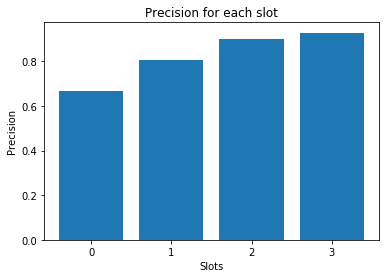

In [895]:
label = [i for i in range(len(precision_list))]
plot_bar(label, 'Slots', 'Precision', 'Precision for each slot', precision_list)

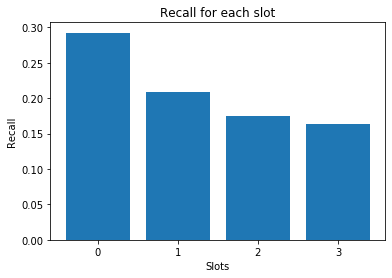

In [896]:
label = [i for i in range(len(recall_list))]
plot_bar(label, 'Slots', 'Recall', 'Recall for each slot', recall_list)